# Test annotated data

In [1]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.methods.dataset import URL_DATA_VAL, URL_DATA_TEST
from lqam.util.file_utils import cached_path
import requests
import json
def load_data_from_link(link, cache_dir='../data/'):
#     return json.loads(requests.get(link).text)
    data = json.load(open(cached_path(link, cache_dir)))
    return data
val_data = load_data_from_link(URL_DATA_VAL)
test_data = load_data_from_link(URL_DATA_TEST)
annotated_data = val_data + test_data

In [2]:
print(len(annotated_data))

1985


In [3]:
## normalize all data
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import normalize_answer
for data_i in annotated_data:
    data_i['label_norm'] = normalize_answer(data_i['label'])
    data_i['annotations_norm'] = [[normalize_answer(y) for y in x] for x in data_i['additional_answers']]

## Noun distribution
Let's look at the top-K nouns for (1) ground-truth data and (2) labeled data.

In [4]:
import pandas as pd
ground_truth_labels = list(map(lambda x: x['label_norm'], annotated_data))
ground_truth_label_counts = pd.Series(ground_truth_labels).value_counts()
display(ground_truth_label_counts.head(20))

man          113
person        56
woman         50
it            46
people        31
group         22
he            20
boy           19
someone       19
them          18
girl          17
front         17
young man     13
camera        13
table         12
piece         12
ball          11
baby          11
child         11
she           10
dtype: int64

In [5]:
from functools import reduce
annotation_labels = []
for annotated_data_i in annotated_data:
    annotations_i = set()
    for annotations_j in annotated_data_i['annotations_norm']:
        # remove duplicate annotations
        annotations_i.update(annotations_j)
    annotation_labels.extend(list(annotations_i))
annotation_label_counts = pd.Series(annotation_labels).value_counts()
display(annotation_label_counts.head(20))

person       405
man          310
guy          229
someone      224
woman        171
girl         153
people       152
boy          140
kid          132
male         127
child        126
lady         125
room          89
group         87
female        83
kids          79
it            76
gentleman     71
human         69
young man     61
dtype: int64

In [7]:
## combine counts for table
combined_label_counts = pd.concat([
    ground_truth_label_counts.reset_index().head(10),
    annotation_label_counts.reset_index().head(10),
], axis=1)
print(combined_label_counts.to_latex(index=False))

\begin{tabular}{lrlr}
\toprule
   index &    0 &    index &    0 \\
\midrule
     man &  113 &   person &  405 \\
  person &   56 &      man &  310 \\
   woman &   50 &      guy &  229 \\
      it &   46 &  someone &  224 \\
  people &   31 &    woman &  171 \\
   group &   22 &     girl &  153 \\
      he &   20 &   people &  152 \\
 someone &   19 &      boy &  140 \\
     boy &   19 &      kid &  132 \\
    them &   18 &     male &  127 \\
\bottomrule
\end{tabular}



In [7]:
## plot both distributions
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
def plot_word_distribution(word_counts, plot_name):
    plt.barh(word_counts.index, word_counts.values)
    plt.xlabel('Count')
    plt.title(f'Top counts for {plot_name}')
    plt.show()

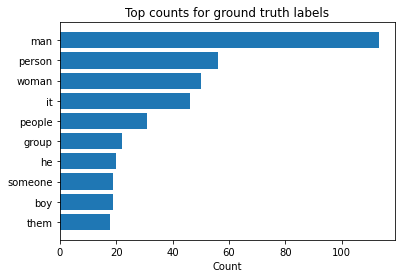

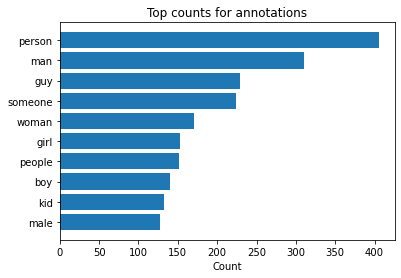

In [9]:
top_k = 10
plot_word_distribution(ground_truth_label_counts.head(top_k).sort_values(ascending=True), 'ground truth labels')
plot_word_distribution(annotation_label_counts.head(top_k).sort_values(ascending=True), 'annotations')

### Nouns with low/high agreement
Which nouns have lower or higher agreement?

In [7]:
from lqam.core.metrics import normalize_answer, tokenize_answer_to_compute_metrics, compute_token_level_f1_many
def compute_overlap_score(label, annotations):
    label_tokens = tokenize_answer_to_compute_metrics(normalize_answer(label))
    annotation_tokens = list(map(lambda x: list(map(lambda y: tokenize_answer_to_compute_metrics(normalize_answer(y)), x)), annotations))
    # flatten token lists
    annotation_tokens = [y for x in annotation_tokens for y in x]
    overlap_score = compute_token_level_f1_many(label_tokens, annotation_tokens)
    return overlap_score

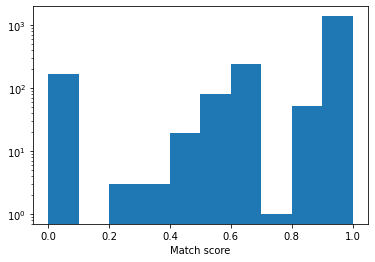

In [8]:
# show distribution first
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
valid_annotated_data = list(filter(lambda x: len(x['additional_answers']) > 0, annotated_data))
overlap_scores = list(map(lambda x: compute_overlap_score(x['label_norm'], x['annotations_norm']), valid_annotated_data))
plt.hist(overlap_scores)
plt.xlabel("Match score")
plt.yscale('log')
plt.show()

In [9]:
import numpy as np
print(f'{(np.array(overlap_scores) == 1.0).sum() / len(overlap_scores)*100}% of captions with at least one complete overlap')

70.91836734693877% of captions with at least one complete overlap


Most questions have fairly low rate of exact matches, which may be unusually low for questions with higher number of annotations provided.

In [10]:
## compute average overlap per NP
valid_annotated_data_labels = list(map(lambda x: x['label_norm'], valid_annotated_data))
label_annotation_overlap = pd.DataFrame(list(zip(valid_annotated_data_labels, overlap_scores)), columns=['label', 'overlap_score'])
label_annotation_overlap_aggregate = label_annotation_overlap.groupby('label').apply(lambda x: x.loc[:, 'overlap_score'].mean())
label_annotation_overlap_aggregate.sort_values(inplace=True, ascending=False)
print('ground-truth labels with highest annotation overlap')
display(label_annotation_overlap_aggregate.head(20))
label_annotation_overlap_aggregate.sort_values(inplace=True, ascending=True)
print('ground-truth labels with lowest annotation overlap')
display(label_annotation_overlap_aggregate.head(20))

ground-truth labels with highest annotation overlap


label
melody                1.0
file                  1.0
needle                1.0
narrator              1.0
napkin fold           1.0
nails                 1.0
bat                   1.0
musical instrument    1.0
music                 1.0
mozzarella cheese     1.0
movie                 1.0
mountain              1.0
few seconds           1.0
motorcycle            1.0
mother                1.0
mosh pit              1.0
monopoly              1.0
mixture               1.0
bathroom              1.0
net                   1.0
dtype: float64

ground-truth labels with lowest annotation overlap


label
45 degree angle    0.0
twine              0.0
top view           0.0
another couple     0.0
top portion        0.0
another item       0.0
timelapse          0.0
twos               0.0
time               0.0
tiedye             0.0
themselves         0.0
their way          0.0
another talks      0.0
tail play          0.0
taekwondo          0.0
swirl              0.0
anvil              0.0
surface            0.0
studio             0.0
project            0.0
dtype: float64

The words with higher agreement tend to be simple and concrete nouns (`motorcycle`, `bat`).

The words with lower agreement tend to be highly specific (`45 degree angle`, `taekwondo`) or vague (`twos`, `time`).

## Tokens per NP
How many tokens on average does each noun phrase contain?

We'll look at this for both ground-truth and annotations.

gold label NPs have 1.467 +/- 0.684 tokens
annotation NPs have 1.359 +/- 0.680 tokens


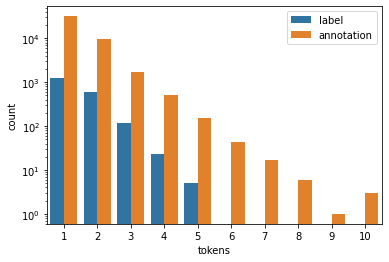

In [11]:
from nltk.tokenize import WordPunctTokenizer
import numpy as np
tokenizer = WordPunctTokenizer()
label_token_counts = list(map(lambda x: len(tokenizer.tokenize(x)), valid_annotated_data_labels))
flat_annotation_labels = [z for x in valid_annotated_data for y in x['annotations_norm'] for z in y]
# remove null labels?
flat_annotation_labels = list(filter(lambda x: len(x) > 0, flat_annotation_labels))
annotation_label_token_counts = [len(tokenizer.tokenize(x)) for x in flat_annotation_labels]
print('gold label NPs have %.3f +/- %.3f tokens'%(np.mean(label_token_counts), np.std(label_token_counts)))
print('annotation NPs have %.3f +/- %.3f tokens'%(np.mean(annotation_label_token_counts), np.std(annotation_label_token_counts)))
## get combined counts => show as bar chart
label_token_count_bins = pd.Series(label_token_counts).value_counts().reset_index().assign(**{'data_type' : 'label'})
annotation_label_token_count_bins = pd.Series(annotation_label_token_counts).value_counts().reset_index().assign(**{'data_type' : 'annotation'})
combined_token_count_bins = pd.concat([
    label_token_count_bins,
    annotation_label_token_count_bins,
]).rename(columns={'index' : 'tokens', 0 : 'count'})
import seaborn as sns
sns.barplot(y='count', x='tokens', data=combined_token_count_bins, hue='data_type')
plt.legend(loc='upper right')
plt.yscale('log')
plt.show()

The gold labels tend to be slightly longer, and annotation labels are more central-skewed (2 words or below) vs. the long tail of tokens in the gold labels.

What are the longest/shortest labels in each set?

In [12]:
label_token_count_data = pd.Series(label_token_counts, index=list(map(lambda x: x.lower(), valid_annotated_data_labels))).sort_values(inplace=False, ascending=False)
flat_annotation_label_token_count_data = pd.Series(annotation_label_token_counts, index=list(map(lambda x: x.lower(), flat_annotation_labels))).sort_values(inplace=False, ascending=False)
label_token_count_data = label_token_count_data[~label_token_count_data.index.duplicated()]
flat_annotation_label_token_count_data = flat_annotation_label_token_count_data[~flat_annotation_label_token_count_data.index.duplicated()]
print('longest gold label NPs')
display(label_token_count_data.head(20))
print('longest annotation NPs')
display(flat_annotation_label_token_count_data.head(20))

longest gold label NPs


innocent cute little baby boy           5
loud and annoying music blares          5
beautiful looking oil based painting    5
black and white knitting kit            5
blue top and black trousers             5
cows back end shows                     4
track and field event                   4
strung out teenage girls                4
jumbo chocolate chip cookies            4
lettuce and blue cheese                 4
another persons belly button            4
basic photo copy machine                4
about nine game pieces                  4
ornately costumed dance squad           4
his toy train set                       4
very well built woman                   4
high school age cheerleaders            4
large multiple dig site                 4
two consecutive back flips              4
human ping pong ball                    4
dtype: int64

longest annotation NPs


2 teams one in yellow jerseys and one white jerseys       10
how she always has handful of dog food to start           10
man who looks like to be in his mid 30s                   10
poor animal who needs its wool to stay warm                9
how to hit golf ball close to hole                         8
male wearing shoes and black pants with stripes            8
2 young kids with shorts and no shirts                     8
cowboy wearing blue jeans and blue jean jacket             8
boy in black and boy in blue tshirt                        8
2 people total and 1 in full view                          8
sample piece of yarn on pair of                            7
how to land just short of green                            7
conversation about how professionalism and ethics help     7
nothing but clothes and equipment on him                   7
how much he is using to clean                              7
while sitting and using fork to eat                        7
2 males wearing blue shi

The longest NPs for the gold labels tend to have multiple adjectives (`an innocent cute little baby boy`) and possessive markers (`his toy train set`).

The longest NPs for the annotation labels tend to have coordination (`boy in black and boy in blue tshirt`) and long, unnecessary subclauses (`poor animal who needs it's wool to stay warm`).

### Chars per token
How long is each token? We expect that the tokens in the original labels will be slightly longer than the tokens for the annotations.

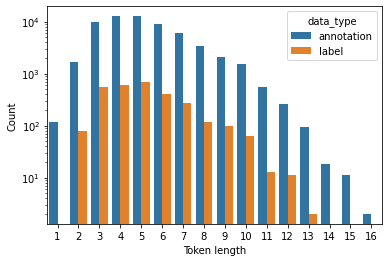

In [13]:
annotated_data_label_tokens = list(map(lambda x: tokenizer.tokenize(x), valid_annotated_data_labels))
annotated_data_annotation_tokens = list(map(lambda x: tokenizer.tokenize(x), flat_annotation_labels))
## flatten
flat_label_tokens = [y for x in annotated_data_label_tokens for y in x]
flat_annotation_tokens = [y for x in annotated_data_annotation_tokens for y in x]
## compute len
label_token_len = list(map(len, flat_label_tokens))
annotation_token_len = list(map(len, flat_annotation_tokens))
## plot 
token_len_data = pd.DataFrame([
    label_token_len + annotation_token_len,
    ['label',]*len(label_token_len) + ['annotation',]*len(annotation_token_len)
], index=['token_len', 'data_type']).transpose()
token_len_count_data = token_len_data.groupby('data_type').apply(lambda x: x.loc[:, 'token_len'].value_counts()).reset_index(name='count').rename(columns={'level_1':'token_len'})
sns.barplot(x='token_len', y='count', hue='data_type', data=token_len_count_data)
plt.xlabel('Token length')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

In [14]:
## get mean + std
print(f'label tokens have mean char len {"{:1.3f}".format(np.mean(label_token_len))} +/- {"{:1.3f}".format(np.std(label_token_len))}')
print(f'annotation tokens have mean char len {"{:1.3f}".format(np.mean(annotation_token_len))} +/- {"{:1.3f}".format(np.std(annotation_token_len))}')

label tokens have mean char len 5.086 +/- 1.892
annotation tokens have mean char len 5.266 +/- 2.005


The annotations are slightly longer than the labels, due to the longer tail of extra-long tokens (annotator creativity?).

### Unique NPs per question
How many unique NPs does each question get?

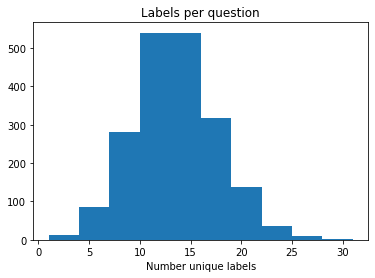

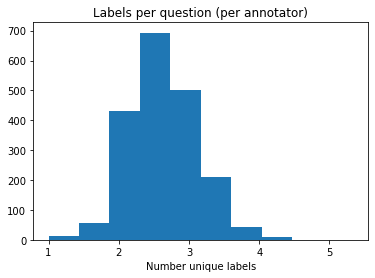

questions have an average of 13.012 +/- 4.135 unique labels
annotators have an average of 2.625 +/- 0.490 unique labels


In [15]:
def get_num_unique_labels_per_annotator(data):
    ## TODO: only include first label from each annotator? some annotators may have included extra words just for bonus
    data_annotation_label_sets = [set([y.lower() for y in x]) for x in data['annotations_norm']]
    num_unique_data_annotation_labels = list(map(lambda x: len(x), data_annotation_label_sets))
    mean_unique_data_annotation_labels = np.mean(num_unique_data_annotation_labels)
    return mean_unique_data_annotation_labels
unique_labels_per_question = list(map(lambda x: list(sorted(set([z.lower() for y in x['annotations_norm'] for z in y]))), valid_annotated_data))
num_unique_labels_per_question = list(map(lambda x: len(x), unique_labels_per_question))
num_unique_labels_per_question_per_annotator = list(map(lambda x: get_num_unique_labels_per_annotator(x), valid_annotated_data))
plt.hist(num_unique_labels_per_question)
plt.xlabel('Number unique labels')
plt.title('Labels per question')
plt.show()
plt.hist(num_unique_labels_per_question_per_annotator)
plt.xlabel('Number unique labels')
plt.title('Labels per question (per annotator)')
plt.show()
print('questions have an average of %.3f +/- %.3f unique labels'%(np.mean(num_unique_labels_per_question), np.std(num_unique_labels_per_question)))
print('annotators have an average of %.3f +/- %.3f unique labels'%(np.mean(num_unique_labels_per_question_per_annotator), np.std(num_unique_labels_per_question_per_annotator)))

Most questions have around 13 unique labels total and 2.6 unique labels per annotator.

Which questions have the most unique labels per annotator?

In [16]:
pd.set_option('display.max_colwidth', 200)
question_prompts = list(map(lambda x: x['masked_caption'], valid_annotated_data))
unique_labels_per_question_per_annotator_data = pd.DataFrame([
    question_prompts,
    num_unique_labels_per_question_per_annotator,
    unique_labels_per_question,
], index=['prompt', 'unique_label_count', 'unique_labels']).transpose()
unique_labels_per_question_per_annotator_data.sort_values('unique_label_count', inplace=True, ascending=False)
print('questions with highest number unique labels per annotator')
display(unique_labels_per_question_per_annotator_data.head(10))
print('questions with lowest number unique labels per annotator')
display(unique_labels_per_question_per_annotator_data.tail(10))

questions with highest number unique labels per annotator


,prompt,unique_label_count,unique_labels
1545,_____ attempts to throw a snowball but it falls out of his hand.,5.33333,"[2 teenagers, 2 young boys, adolescent, boy, brother, child, guy, juvenile, kid, kiddo, lad, lass, male, man, man in black pants, man in blue coat, minor, person, schoolboy, son, teen, teenager, y..."
1546,_____ stands in front of a stone wall then jumps towards it and rebounds off it with his legs.,4.55556,"[atheletic boy, boy, child, dude, fellow, juvenile, kid, kiddo, lad, man, man in blue shirt, man in blue shorts, person, player, teen, teenager, young adult, young boy, young child, young kid, you..."
1037,_____ have a pillow fight and then argue about only using pillows.,4.44444,"[both kids, boy and his younger brother, boys, brothers, children, couple of boys, couple of children, couple of kids, couple of young boys, cousins, family members, friends, kids, pair of boys, p..."
1322,_____ demonstrates how to unlock and open a window.,4.375,"[assistant of shop, building inspector, contractor, employee, gentleman, guy, guy wearing blue shirt, guy wearing cap, handyman, installer, instructor, male, man, person, safety inspector, salesma..."
936,_____ kicks soccer balls into a net while on a grass field.,4.33333,"[adolescent, athlete, boy, child, guy, human, kid, male, my daughters friend, our neighbor, person, player, players, soccer player, someone, son, team member, teams captain, young boy, youth]"
1634,_____ is in front of a crowd with a sword inside his mouth going up to people's faces to show.,4.125,"[adult, crazy person, daredevil, guy, human, human male, magician, man, man with black shirt, person, person with black shirt, some guy, someone, sword eater, sword swallower, tall man, this dude]"
590,_____ peels a potato with an extra large peeler than can also be used on zucchini.,4.125,"[chef, cook, female, female chef, female cook, girl, host, lady, mother, older chef, older cook, older woman, person, some lady in her kitchen, someone, woman]"
606,_____ is styling a person's hair using a blow dryer and brush.,4.11111,"[barber, beautician, businessperson, cosmetologist, educator, female hairdresser, girl, hair stylist, hairdresser, lady, person, someone, stylist, woman, woman hairdresser, womens hairstylist, you..."
158,_____ are each wrapping Christmas presents on a coffee table.,4.11111,"[2 boys, 2 kids, 3 boys, boys, brothers, children, kids, little boys, little kids, people, siblings, two boys, two boys in pajamas, two children, two kids in pajamas, two little boys, two little c..."
1548,_____ is digging a hole in the sand at the beach while an unseen male talks and there is a dog and two other girls with her.,4.11111,"[adolescent, adolesent, chick, child, chilly woman with coat on, female, female child, gal, girl, ivy, juvenile, lady, little girl, man, middle aged woman, minor, mother, person, sister, teen, tee..."


questions with lowest number unique labels per annotator


,prompt,unique_label_count,unique_labels
721,A young boy who seems to be timing _____ how fast he can eat a snack.,1.28571,"[challenge of, himself, his self, recording of, to calculate, to see]"
1014,A shirtless person lifts a barbell and _____ at a gym.,1.25,"[his body, his torso, weights]"
706,Packages of paper are being wrapped in paper plastic and stacked on _____ of each other.,1.25,"[device next, machine, row, side, top]"
1007,"A group of people are riding donkeys, some people are riding and _____ are just standing by them.",1.16667,"[other people, others]"
989,A pair of bikers drive around _____ sphere as the crowd cheers them.,1,[form of]
847,A person is showing how _____ open a beer with a screw driver indoors.,1,"[he, people, to screw open, you]"
1169,A woman with _____ her face with a towel.,1,[moisturizer]
1686,A child is _____ and does not seem to be happy about it.,1,[bath]
1225,A woman is exercising with dumb bells and another woman whispers _____.,1,"[encouraging words, her name, to stop]"
142,A baby is listening to a lady's song as _____.,1,[smiles]


Questions with higher number of unique labels seem to inspire creative answers (`____ kicks soccer balls into a net` => different paraphrases for `player`) and address multiple possible aspects of an event due to ambiguity (`____ are each wrapping` => different configurations of children).

Questions with lower number of unique labels seem to have very specific scenarios without room for paraphrasing or ambiguity (`___ at gym` => can only add `weights` as logical caption).

### Assessing visual cues
Some nouns and adjectives have more obvious visual cues than others, ex. "green" has clear visual component whereas "kind" is more subjective.

Let's look for these visual cues in the labels and annotations using some word lists:
- color
- size
- number

In [28]:
## TODO: expand word sets using word embeddings (nearest neighbors + filtering)
color_words = {
    'red', 'blue', 'green', 'yellow', 'purple', 'orange', 'black', 'white', 'gray', 'grey',
    'colorful', 'painted',
}
size_words = {
    'large', 'huge', 'giant', 'small', 'little', 'tiny',
}
number_words = {
    'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'several', 'few', 'many',
}
combined_visual_words = (color_words | size_words | number_words)
visual_word_sets = [
    color_words, size_words, number_words, combined_visual_words,
]
visual_word_set_names = [
    'color', 'size', 'number', 'combined'
]

In [18]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import tokenize_answer_to_compute_metrics
## tokenize everything
label_tokens = list(map(lambda x: tokenize_answer_to_compute_metrics(x['label_norm']), annotated_data))
annotation_label_tokens = [[tokenize_answer_to_compute_metrics(z) for z in y] for x in valid_annotated_data for y in x['annotations_norm']]

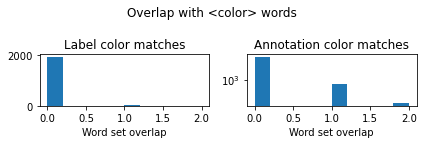

proportion of <color> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.981864                   0.987882
1           1              0.017128                   0.011665
2           2              0.001008                   0.000453
percent of labels with >= 1 matches: 
label_word_match_pct         0.018136
annotation_word_match_pct    0.012118
dtype: float64


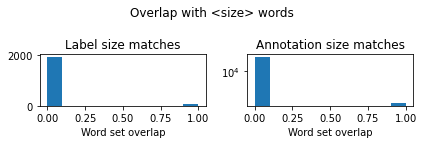

proportion of <size> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.971285                   0.990691
1           1              0.028715                   0.009309
percent of labels with >= 1 matches: 
label_word_match_pct         0.028715
annotation_word_match_pct    0.009309
dtype: float64


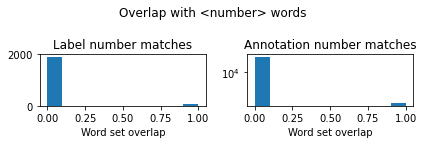

proportion of <number> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.961713                   0.987882
1           1              0.038287                   0.012118
percent of labels with >= 1 matches: 
label_word_match_pct         0.038287
annotation_word_match_pct    0.012118
dtype: float64


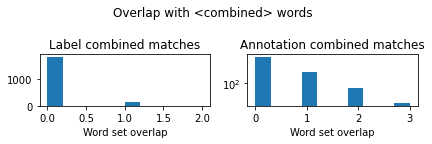

proportion of <combined> word matches for labels:
   word_count  label_word_match_pct  annotation_word_match_pct
0           0              0.917884                   0.966862
1           1              0.078086                   0.032300
2           2              0.004030                   0.000815
3           3                   NaN                   0.000023
percent of labels with >= 1 matches: 
label_word_match_pct         0.082116
annotation_word_match_pct    0.033138
dtype: float64


In [20]:
## get counts, plot distribution of visual words
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
for visual_word_set, visual_word_set_name in zip(visual_word_sets, visual_word_set_names):
    label_word_matches = list(map(lambda x: set(x) & visual_word_set, label_tokens))
    annotation_label_word_matches = [set(y) & visual_word_set for x in annotation_label_tokens for y in x]
    num_label_word_matches = list(map(lambda x: len(x), label_word_matches))
    num_annotation_label_word_matches = list(map(lambda x: len(x), annotation_label_word_matches))
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
    axs[0].hist(num_label_word_matches)
    axs[1].hist(num_annotation_label_word_matches)
    axs[0].set_title(f'Label {visual_word_set_name} matches')
    axs[1].set_title(f'Annotation {visual_word_set_name} matches')
    axs[0].set_xlabel('Word set overlap')
    axs[1].set_xlabel('Word set overlap')
    plt.suptitle(f'Overlap with <{visual_word_set_name}> words')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    # compute proportion of visual words per question
    pct_label_word_matches = pd.Series(num_label_word_matches).value_counts() / len(num_label_word_matches)
    pct_annotation_label_word_matches = pd.Series(num_annotation_label_word_matches).value_counts() / len(num_annotation_label_word_matches)
    pct_word_matches = pd.concat([pct_label_word_matches, pct_annotation_label_word_matches], axis=1).reset_index().fillna(0.)
    pct_word_matches.columns = ['word_count', 'label_word_match_pct', 'annotation_word_match_pct']
#     pct_word_matches.columns = ['label_match_pct', 'annotation_label_match_pct']
    print(f'proportion of <{visual_word_set_name}> word matches for labels:\n{pct_word_matches}')
    # simplify: percent with >=1 words
    above_1_pct_word_matches = pct_word_matches[pct_word_matches.loc[:, 'word_count'] >= 1].iloc[:, 1:].sum(axis=0)
    print(f'percent of labels with >= 1 matches: \n{above_1_pct_word_matches}')

Overall, the annotations tend to have about the rate of color words as the labels, but the annotations also have fewer size and number words than the labels.

What are some example questions where the label contains a visual word but the annotations do not?

In [21]:
## get aligned/valid data
valid_label_tokens = list(map(lambda x: tokenize_answer_to_compute_metrics(x['label_norm']), valid_annotated_data))
valid_annotation_label_tokens = [[tokenize_answer_to_compute_metrics(z) for y in x['annotations_norm'] for z in y] for x in valid_annotated_data]
# flatten tokens
valid_annotation_label_tokens = [[z for y in x for z in y] for x in valid_annotation_label_tokens]
sample_size = 10
for visual_word_set, visual_word_set_name in zip(visual_word_sets, visual_word_set_names):
    print(f'*~*~*~* testing word set {visual_word_set_name} *~*~*~*')
    label_word_matches = list(map(lambda x: set(x) & visual_word_set, valid_label_tokens))
    annotation_label_word_matches = list(map(lambda x: set(x) & visual_word_set, valid_annotation_label_tokens))
    sample_ctr = 0
    for data_i, label_word_matches_i, annotation_label_word_matches_i in zip(valid_annotated_data, label_word_matches, annotation_label_word_matches):
        if(len(label_word_matches_i) > 0 and len(annotation_label_word_matches_i) == 0):
            print(f'caption=<{data_i["caption"]}>')
            print(f'label=<{data_i["label"]}> has matches <{label_word_matches_i}>')
            print(f'annotations do not have matches: <{data_i["additional_answers"]}>')
            print('---------')
            sample_ctr += 1
            if(sample_ctr >= sample_size):
                break

*~*~*~* testing word set color *~*~*~*
caption=<A red hot piece of bent steel is being formed with a metal sledge hammer on the end of a  steel table.>
label=<A red hot piece> has matches <{'red'}>
annotations do not have matches: <[['A horseshoe', 'A shoe', 'An arch', 'A U-shape', 'An object'], ['A piece', 'A horseshoe'], ['a rod', 'a segment'], ['hot iron'], ['A large are', 'A big area'], ['A piece', 'A long piece', 'A hot piece'], ['A piece', 'A rod', 'A chunk'], ['A piece', 'A part'], ['A piece', 'A heated piece']]>
---------
caption=<A gir lis trying to stitching up the black and white knitting kit with a knitting needle.>
label=<the black and white knitting kit> has matches <{'white', 'black'}>
annotations do not have matches: <[['string', 'lace work'], ['the neckerchief', 'the scarf'], ['a scarf', 'a line on a scarf'], ['yarn', 'cloth'], ['a piece of clothing', 'some cloth'], ['a scarf', 'fancy yarn'], ['a scarf', 'her scarf'], ['crochet', 'string', 'thread'], ['a scarf', 'some 

- Color: the mismatches are due to highly specific captions, no necessary information being conveyed by the color.
- Size: the mismatches are due to annotators focusing more on paraphrases for the noun (`little baby`: `child`, `infant`) and different aspects of the scene (`large group`: `group`, `skill`).
- Number: the mismatches are due to annotators focusing more on paraphrases for the noun (`two large barbells`: `equipment`, `weights`) and different aspects of the scene (`three wine glasses`: `dishes`, `glasses`).

### Syntactic complexity
Let's look at the relative complexity of the NPs provided by the annotations.

We'll use `spacy` for parsing.

In [22]:
import spacy
nlp_pipeline = spacy.load('en_core_web_sm')
test_text = 'this is a test sentence with a complicated noun that has a lot of extra information'
test_text_parse = nlp_pipeline(test_text)
print(test_text_parse)

this is a test sentence with a complicated noun that has a lot of extra information


In [23]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.noun_phrases import is_phrase
def extract_noun_subtree(noun, start_idx, parse):
    noun_tokens = []
    # get span
    end_idx = start_idx + len(noun)
    subtree = parse.char_span(start_idx, end_idx)
    if(subtree is not None and is_phrase(subtree)):
        return subtree
    else:
        return ''
test_noun = 'a complicated noun that has a lot of extra information'
start_idx = test_text.index(test_noun)
test_noun_subtree = extract_noun_subtree(test_noun, start_idx, test_text_parse)
print(test_noun_subtree)

a complicated noun that has a lot of extra information


In [27]:
## get start index
mask_token = '_____'
for data_i in annotated_data:
    data_i.update({'mask_start_idx' : data_i['masked_caption'].index(mask_token)})
assert annotated_data[0]['mask_start_idx'] == 53

In [28]:
# parse all possible sentences based on annotations, generate sub-trees
def parse_extract_noun_subtree(mask_sent, noun, nlp_pipeline, start_idx, mask_token='_____'):
    sent = mask_sent.replace(mask_token, noun)
    parse = nlp_pipeline(sent)
    subtree = extract_noun_subtree(noun, start_idx, parse)
    return subtree
def extract_all_annotation_subtrees(data, nlp_pipeline):
    mask_token = '_____'
    for i, data_i in enumerate(data):
        start_idx_i = data_i['mask_start_idx']
        mask_sent_i = data_i['masked_caption']
        # get subtree for label
        label_i = data_i['label']
        label_subtree_i = parse_extract_noun_subtree(mask_sent_i, label_i, nlp_pipeline, start_idx_i, mask_token=mask_token)
        data_i['label_subtree'] = label_subtree_i
        annotation_label_subtrees = []
        for annotation_label_list_j in data_i['additional_answers']:
            annotation_label_subtrees_j = []
            for annotation_label_k in annotation_label_list_j:
                annotation_subtree_k = parse_extract_noun_subtree(mask_sent_i, annotation_label_k, nlp_pipeline, start_idx_i, mask_token=mask_token)
                annotation_label_subtrees_j.append(annotation_subtree_k)
            annotation_label_subtrees.append(annotation_label_subtrees_j)
        data_i['annotation_subtrees'] = annotation_label_subtrees
        if(i % 100 == 0):
            print(f'processed {i} data')
    return data
annotated_data = extract_all_annotation_subtrees(annotated_data, nlp_pipeline)

processed 0 data
processed 100 data
processed 200 data
processed 300 data
processed 400 data
processed 500 data
processed 600 data
processed 700 data
processed 800 data
processed 900 data
processed 1000 data
processed 1100 data
processed 1200 data
processed 1300 data
processed 1400 data
processed 1500 data
processed 1600 data
processed 1700 data
processed 1800 data
processed 1900 data


In [29]:
display(annotated_data[0])

{'video_id': 'cfBtVPEwqIo',
 'video_start_time': 5,
 'video_end_time': 15,
 'caption': 'In a gym with someone spotting him, a man is lifting weights performing squats in a squat rack.',
 'masked_caption': 'In a gym with someone spotting him, a man is lifting _____ performing squats in a squat rack.',
 'label': 'weights',
 'additional_answers': [['a weight', 'some weights', 'a squat bar'],
  ['weight', 'a bar'],
  ['weights', 'a barbell'],
  ['weights', 'a heavy load'],
  ['weights', 'a barbell'],
  ['weights', 'iron', 'equipment'],
  ['weights', 'a barbell', 'a weight'],
  ['weights', '405 lb']],
 'label_norm': 'weights',
 'annotations_norm': [['weight', 'some weights', 'squat bar'],
  ['weight', 'bar'],
  ['weights', 'barbell'],
  ['weights', 'heavy load'],
  ['weights', 'barbell'],
  ['weights', 'iron', 'equipment'],
  ['weights', 'barbell', 'weight'],
  ['weights', '405 lb']],
 'mask_start_idx': 53,
 'label_subtree': weights,
 'annotation_subtrees': [[a weight, some weights, ''],
  

How many labels have extra descriptive information?

In [30]:
from collections import defaultdict
def has_descriptor(subtree):
    # adjective
    # get head noun
    head_noun = subtree.root
    subtree_token_ids = list(map(lambda x: x.idx, subtree))
    # get immediate head noun children
    head_noun_children = list(filter(lambda x: x.idx in subtree_token_ids, list(head_noun.children)))
    has_descriptor = any(list(map(lambda x: x.pos_=='ADJ', head_noun_children)))
    return has_descriptor
# def has_subclause(subtree):
#     # has PREP or COORD
#     pass

In [31]:
test_subtree_1 = annotated_data[0]['annotation_subtrees'][3][1] # true "a heavy load"
test_subtree_2 = annotated_data[0]['annotation_subtrees'][1][1] # false "a bar"
assert has_descriptor(test_subtree_1)
assert not has_descriptor(test_subtree_2)

In [32]:
## get descriptors for everything
from spacy.tokens.span import Span
annotation_descriptors = [[[type(z) is Span and has_descriptor(z) for z in y] for y in x['annotation_subtrees']] for x in annotated_data]
label_descriptors = [type(x['label_subtree']) is Span and has_descriptor(x['label_subtree']) for x in annotated_data]

What are some example labels and annotations with adjectives?

In [33]:
## labels
import numpy as np
np.random.seed(123)
sample_size = 10
label_descriptor_idx = np.where(np.array(label_descriptors))[0]
sample_label_descriptor_idx = np.random.choice(label_descriptor_idx, sample_size, replace=False)
print('sample labels with descriptor information')
for sample_idx_i in sample_label_descriptor_idx:
    print(annotated_data[sample_idx_i]['label_subtree'])
## annotations
sample_annotation_descriptor_idx = []
for i, data_i in enumerate(annotation_descriptors):
    for j, data_j in enumerate(data_i):
        for k, data_k in enumerate(data_j):
            if(data_k):
                sample_annotation_descriptor_idx.append([i,j,k])
sample_annotation_descriptor_idx = np.array(sample_annotation_descriptor_idx)
np.random.shuffle(sample_annotation_descriptor_idx)
sample_annotation_descriptor_idx = sample_annotation_descriptor_idx[:sample_size]
print('sample annotations with descriptor information')
for i,j,k in sample_annotation_descriptor_idx:
    print(annotated_data[i]['annotation_subtrees'][j][k])

sample labels with descriptor information
a fake bull
aboutthe operation
a small body
a large needle
white rocks
a young woman
a windy golf course
Several people
A black dog
an old ad
sample annotations with descriptor information
A chilly woman with a coat on
a windy day
A clerical leader
fake heads
a medium number
fried dough
a clear board
dark-haired man
a gentle ski slope
her little boy


The labels and annotations seem to use mostly visual adjectives (`large`, `white`, `black`) as well as some subjective ones (`gentle`, `young`, `chilly`).

Do labels and annotations tend to use the same adjectives?

In [34]:
import pandas as pd
sample_size = 20
## labels
label_descriptors_combined = []
for has_descriptor_i, data_i in zip(label_descriptors, annotated_data):
    if(has_descriptor_i):
        descriptors_i = list(filter(lambda x: x.pos_=='ADJ', data_i['label_subtree']))
        descriptors_i = list(map(lambda x: x.text.lower(), descriptors_i))
        label_descriptors_combined.extend(descriptors_i)
label_descriptor_count = pd.Series(label_descriptors_combined).value_counts()
print('top descriptor adjectives for labels')
display(label_descriptor_count.head(sample_size))
## annotations
annotation_descriptors_combined = []
for has_descriptor_i, data_i in zip(annotation_descriptors, annotated_data):
    for has_descriptor_j, data_j in zip(has_descriptor_i, data_i['annotation_subtrees']):
        for has_descriptor_k, data_k in zip(has_descriptor_j, data_j):
            if(has_descriptor_k):
                descriptors_k = list(filter(lambda x: x.pos_=='ADJ', data_k))
                descriptors_k = list(map(lambda x: x.text.lower(), descriptors_k))
                annotation_descriptors_combined.extend(descriptors_k)
annotation_descriptor_count = pd.Series(annotation_descriptors_combined).value_counts()
print('top descriptor adjectives for annotations')
display(annotation_descriptor_count.head(sample_size))

top descriptor adjectives for labels


young        45
large        24
little       19
small        14
white         7
black         7
older         7
other         6
blue          6
several       6
different     6
yellow        5
various       5
long          5
big           4
high          4
teenage       4
wooden        4
outdoor       3
top           3
dtype: int64

top descriptor adjectives for annotations


young        459
little       141
small        129
large        102
white        100
black         98
other         93
older         66
long          54
red           52
sharp         46
blue          45
old           43
different     41
musical       40
big           35
heavy         35
yellow        34
wooden        33
female        28
dtype: int64

- Descriptor adjectives for label phrases include age, size, number words.
- Descriptor adjectives for annotation phrases include situation-specific (`female`, `musical`) words.

Do annotations tend to use more adjectives than original labels?

In [35]:
label_descriptor_use_rate = sum(label_descriptors) / len(annotated_data)
total_annotation_descriptors_combined = sum([sum([len(y) for y in x['additional_answers']]) for x in annotated_data])
annotation_descriptor_use_rate = len(annotation_descriptors_combined) / total_annotation_descriptors_combined
print(f'true labels have %.3f%% descriptor use'%(label_descriptor_use_rate*100))
print(f'annotation labels have %.3f%% descriptor use'%(annotation_descriptor_use_rate*100))
## is this significant?
from scipy.stats import chi2_contingency
contingency_table = [
    [sum(label_descriptors), len(annotated_data) - sum(label_descriptors)], # true label
    [len(annotation_descriptors_combined), total_annotation_descriptors_combined - len(annotation_descriptors_combined)], # annotation label
]
chi2, p_val, dof, expected = chi2_contingency(contingency_table)
print('rate of descriptor use is different with stat=%.3f (p=%.3E)'%(chi2, p_val))

true labels have 15.365% descriptor use
annotation labels have 8.553% descriptor use
rate of descriptor use is different with stat=108.486 (p=2.103E-25)


OK! The labels tend to use descriptors at a significantly higher rate than the annotations.

## POS distribution
Let's look at the overall POS distribution in the labels and annotations.

In [36]:
import pandas as pd
def get_POS_counts(subtree):
    return pd.Series([x.pos_ for x in subtree]).value_counts()
label_POS_counts = pd.concat(list(map(lambda x: get_POS_counts(x['label_subtree']), annotated_data)), axis=1).fillna(0.).sum(axis=1)
annotation_POS_counts = pd.concat([get_POS_counts(z) for x in annotated_data for y in x['annotation_subtrees'] for z in y if type(z) is Span], axis=1).fillna(0.).sum(axis=1)
## normalize values
label_POS_counts = label_POS_counts / label_POS_counts.sum()
annotation_POS_counts = annotation_POS_counts / annotation_POS_counts.sum()
# combine for plotting
combined_POS_counts = pd.concat([
    label_POS_counts.reset_index(name='count').rename(columns={'index' : 'POS'}).assign(**{'data_type' : 'label'}),
    annotation_POS_counts.reset_index(name='count').rename(columns={'index' : 'POS'}).assign(**{'data_type' : 'annotation'}),
])
display(combined_POS_counts.head())

<ipython-input-36-358325fe4076>:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  annotation_POS_counts = pd.concat([get_POS_counts(z) for x in annotated_data for y in x['annotation_subtrees'] for z in y if type(z) is Span], axis=1).fillna(0.).sum(axis=1)


,POS,count,data_type
0,ADJ,0.084459,label
1,ADP,0.000491,label
2,ADV,0.003437,label
3,AUX,0.000246,label
4,CCONJ,0.001473,label


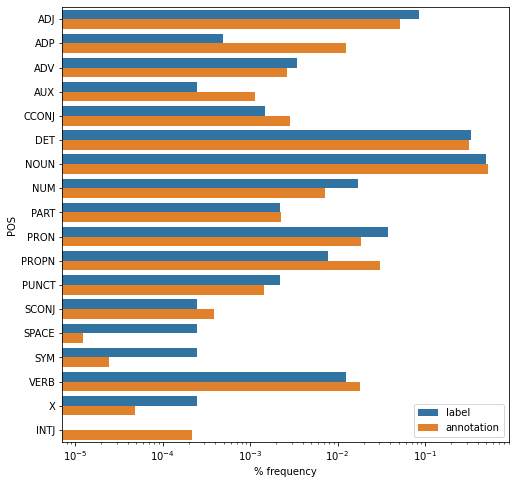

In [37]:
## plot combined
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
sns.barplot(x='count', y='POS', hue='data_type', data=combined_POS_counts)
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlabel('% frequency')
plt.ylabel('POS')
plt.show()

What are the top words in each category?

In [40]:
## get POS/word counts
label_POS_word_counts = []
annotation_POS_word_counts = []
for data_i in annotated_data:
    label_POS_word_counts.extend([(x.text.lower(), x.pos_) for x in data_i['label_subtree']])
    for subtrees_j in data_i['annotation_subtrees']:
        for subtree_k in subtrees_j:
            if(type(subtree_k) is Span):
                annotation_POS_word_counts.extend([(x.text.lower(), x.pos_) for x in subtree_k])
## get aggregate counts!!
label_POS_word_counts = pd.DataFrame(label_POS_word_counts, columns=['word', 'POS'])
annotation_POS_word_counts = pd.DataFrame(annotation_POS_word_counts, columns=['word', 'POS'])
label_POS_word_counts = label_POS_word_counts.groupby('POS').apply(lambda x: x.loc[:, 'word'].value_counts()).reset_index(name='count').rename(columns={'level_1' : 'word'})
annotation_POS_word_counts = annotation_POS_word_counts.groupby('POS').apply(lambda x: x.loc[:, 'word'].value_counts()).reset_index(name='count').rename(columns={'level_1' : 'word'})

In [41]:
for POS_tag_i in combined_POS_counts.loc[:, 'POS'].unique():
    print(f'POS tag {POS_tag_i}')
    label_POS_word_counts_i = label_POS_word_counts[label_POS_word_counts.loc[:, 'POS']==POS_tag_i].sort_values('count', inplace=False, ascending=False).loc[:, ['word', 'count']]
    annotation_POS_word_counts_i = annotation_POS_word_counts[annotation_POS_word_counts.loc[:, 'POS']==POS_tag_i].sort_values('count', inplace=False, ascending=False).loc[:, ['word', 'count']]
    print('label word counts')
    display(label_POS_word_counts_i.head(10))
    print('annotation word counts')
    display(annotation_POS_word_counts_i.head(10))

POS tag ADJ
label word counts


,word,count
0,young,45
1,large,24
2,little,19
3,small,14
4,black,8
5,white,8
6,older,7
7,blue,7
8,different,6
10,several,6


annotation word counts


,word,count
0,young,465
1,little,142
2,small,130
3,black,122
4,white,115
5,large,102
6,other,101
7,older,66
8,blue,64
9,long,59


POS tag ADP
label word counts


,word,count
144,up,1
145,out,1


annotation word counts


,word,count
787,of,653
788,in,138
789,with,70
790,on,55
791,up,20
792,for,18
793,to,15
794,out,10
795,from,9
796,above,6


POS tag ADV
label word counts


,word,count
146,very,4
147,curly,2
148,then,1
149,well,1
150,ornately,1
151,about,1
152,dimly,1
153,back,1
154,extremely,1
155,backflip,1


annotation word counts


,word,count
809,how,49
810,back,16
811,else,14
812,very,11
813,well,8
814,curly,5
817,bong,4
818,chalk,4
819,around,4
816,just,4


POS tag AUX
label word counts


,word,count
156,do,1


annotation word counts


,word,count
893,is,26
894,'s,21
895,being,9
896,are,7
897,do,7
898,was,5
899,have,5
900,has,4
901,be,3
902,did,3


POS tag CCONJ
label word counts


,word,count
157,and,6


annotation word counts


,word,count
907,and,226
908,both,3
909,or,2
910,&,1


POS tag DET
label word counts


,word,count
158,a,948
159,the,187
160,his,63
161,an,44
162,her,39
163,their,25
164,another,24
165,some,11
166,both,4
167,each,3


annotation word counts


,word,count
911,a,16712
912,the,5708
913,an,1211
914,his,1086
915,her,791
916,some,256
917,their,252
918,another,203
919,this,49
920,that,38


POS tag NOUN
label word counts


,word,count
171,man,134
172,person,65
173,woman,64
174,boy,46
175,people,45
176,girl,33
177,group,28
178,ball,19
179,music,18
180,room,17


annotation word counts


,word,count
940,man,1779
941,person,1287
942,woman,898
943,people,623
944,girl,595
945,boy,582
946,child,508
947,guy,508
948,group,414
949,lady,330


POS tag NUM
label word counts


,word,count
1013,two,50
1014,three,10
1015,one,5
1016,four,2
1017,nine,1
1018,45,1


annotation word counts


,word,count
5361,two,349
5362,one,81
5363,2,62
5364,three,27
5365,four,14
5366,3,13
5367,4,6
5368,2000,4
5369,5,4
5370,1,4


POS tag PART
label word counts


,word,count
1019,'s,9


annotation word counts


,word,count
5384,to,92
5385,'s,87
5386,not,4
5387,n't,1
5388,',1


POS tag PRON
label word counts


,word,count
1020,it,46
1021,he,20
1022,someone,19
1023,them,18
1024,she,10
1025,they,7
1026,himself,6
1027,something,6
1028,her,5
1029,him,4


annotation word counts


,word,count
5389,someone,371
5390,it,234
5391,he,183
5392,she,102
5393,them,97
5394,something,94
5395,himself,71
5396,him,48
5397,her,44
5398,they,43


POS tag PROPN
label word counts


,word,count
1036,young,1
1037,triangular,1
1066,bill,1
1065,spanish,1
1064,english,1
1063,teenage,1
1062,teams,1
1061,a,1
1060,diagram,1
1059,para,1


annotation word counts


,word,count
5424,male,61
5425,kid,58
5426,guy,46
5427,man,45
5428,lady,38
5429,girl,27
5430,female,26
5431,worker,24
5432,boy,23
5433,adults,22


POS tag PUNCT
label word counts


,word,count
1068,-,9


annotation word counts


,word,count
6564,-,98
6565,",",15
6566,',3
6567,.,1
6568,},1
6569,/,1


POS tag SCONJ
label word counts


,word,count
1069,like,1


annotation word counts


,word,count
6570,while,15
6571,like,10
6572,out,3
6573,than,1
6574,that,1
6575,as,1
6576,near,1


POS tag SPACE
label word counts


,word,count
1070,,1


annotation word counts


,word,count
6577,,1


POS tag SYM
label word counts


,word,count
1071,/,1


annotation word counts


,word,count
6578,/,2


POS tag VERB
label word counts


,word,count
1072,lit,3
1097,flowered,1
1099,sowing,1
1100,ear,1
1101,riding,1
1102,charges,1
1103,cut,1
1104,motorized,1
1105,colored,1
1106,building,1


annotation word counts


,word,count
6579,wearing,58
6580,dancing,23
6581,playing,20
6582,sitting,19
6583,moving,17
6584,make,15
6585,doing,15
6586,boy,14
6587,cleaning,13
6588,holding,13


POS tag X
label word counts


,word,count
1121,blacksmith,1


annotation word counts


,word,count
7232,2,1
7233,f,1
7234,zag,1
7235,implement,1


POS tag INTJ
label word counts


,word,count


annotation word counts


,word,count
936,boy,14
937,man,2
938,dj,1
939,right,1


### POS tag sequences
Let's look at the relative frequency of different tag sequences in the labels and annotations.

In [42]:
from spacy.tokens.span import Span
def get_POS_sequence(subtree):
    return '_'.join([x.pos_ for x in subtree])
label_POS_sequences = [(x['label_subtree'], get_POS_sequence(x['label_subtree'])) for x in annotated_data if type(x['label_subtree']) is Span]
annotation_POS_sequences = [(z, get_POS_sequence(z)) for x in annotated_data for y in x['annotation_subtrees'] for z in y if type(z) is Span]
label_POS_sequences = pd.DataFrame(label_POS_sequences, columns=['word', 'POS_sequence'])
annotation_POS_sequences = pd.DataFrame(annotation_POS_sequences, columns=['word', 'POS_sequence'])
# fix words
label_POS_sequences = label_POS_sequences.assign(**{'word' : label_POS_sequences.loc[:, 'word'].apply(lambda x: x.text.lower())})
annotation_POS_sequences = annotation_POS_sequences.assign(**{'word' : annotation_POS_sequences.loc[:, 'word'].apply(lambda x: x.text.lower())})
# label_POS_sequences = label_POS_sequences[label_POS_sequences.loc[:, 'POS_sequence']!='']
# annotation_POS_sequences = annotation_POS_sequences[annotation_POS_sequences.loc[:, 'POS_sequence']!='']
## get aggregate counts
label_POS_sequence_counts = label_POS_sequences.loc[:, 'POS_sequence'].value_counts()
annotation_POS_sequence_counts = annotation_POS_sequences.loc[:, 'POS_sequence'].value_counts()
# normalize
label_POS_sequence_counts = label_POS_sequence_counts / label_POS_sequence_counts.sum()
annotation_POS_sequence_counts = annotation_POS_sequence_counts / annotation_POS_sequence_counts.sum()

In [43]:
## combine for plotting 
combined_POS_sequence_counts = pd.concat([
    label_POS_sequence_counts.reset_index(name='count').rename(columns={'index' : 'POS_sequence'}).assign(**{'data_type' : 'label'}),
    annotation_POS_sequence_counts.reset_index(name='count').rename(columns={'index' : 'POS_sequence'}).assign(**{'data_type' : 'annotation'}),
], axis=0)
display(combined_POS_sequence_counts)
top_k = 20
top_k_POS_sequences = combined_POS_sequence_counts.groupby('POS_sequence').apply(lambda x: x.loc[:, 'count'].mean()).sort_values(inplace=False, ascending=False).index[:top_k]

,POS_sequence,count,data_type
0,DET_NOUN,0.481897,label
1,NOUN,0.132585,label
2,DET_ADJ_NOUN,0.087710,label
3,PRON,0.078021,label
4,DET_NOUN_NOUN,0.059153,label
...,...,...,...
620,ADV_PRON_VERB_VERB_DET_NOUN,0.000023,annotation
621,DET_NOUN_PRON_VERB,0.000023,annotation
622,NOUN_PUNCT_PROPN,0.000023,annotation
623,NOUN_ADV_VERB_ADV,0.000023,annotation


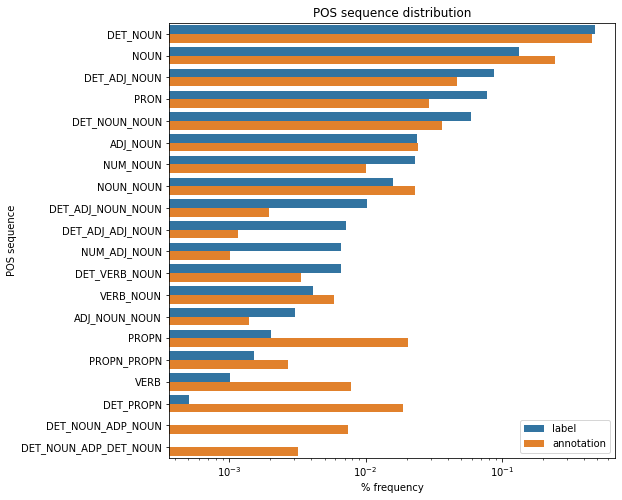

In [44]:
## plot counts
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.barplot(x='count',y='POS_sequence', hue='data_type',
    data=combined_POS_sequence_counts[combined_POS_sequence_counts.loc[:, 'POS_sequence'].isin(top_k_POS_sequences)])
plt.xscale('log')
plt.legend(loc='lower right')
plt.title('POS sequence distribution')
plt.xlabel('% frequency')
plt.ylabel('POS sequence')
plt.xscale('log')
plt.show()

Fewer pronouns for annotations than for labels. Similar levels of adjectives.

In [45]:
## most frequent words for different sequences
top_k = 10
for POS_sequence_i in label_POS_sequence_counts.index[:top_k]:
    print(f'testing POS sequence {POS_sequence_i}')
    label_POS_sequences_i = label_POS_sequences[label_POS_sequences.loc[:, 'POS_sequence']==POS_sequence_i]
    annotation_POS_sequences_i = annotation_POS_sequences[annotation_POS_sequences.loc[:, 'POS_sequence']==POS_sequence_i]
    ## get counts
    label_word_counts_i = label_POS_sequences_i.loc[:, 'word'].value_counts()
    annotation_word_counts_i = annotation_POS_sequences_i.loc[:, 'word'].value_counts()
    # normalize
    label_word_counts_i = label_word_counts_i / label_word_counts_i.sum()
    annotation_word_counts_i = annotation_word_counts_i / annotation_word_counts_i.sum()
    print(f'label word counts\n{label_word_counts_i.head(10)}')
    print(f'annotation word counts\n{annotation_word_counts_i.head(10)}')

testing POS sequence DET_NOUN
label word counts
a man         0.108995
a person      0.059259
a woman       0.049735
a group       0.023280
a boy         0.020106
a girl        0.016931
a piece       0.012698
a table       0.010582
a child       0.009524
the camera    0.008466
Name: word, dtype: float64
annotation word counts
a man       0.052672
a person    0.048593
a woman     0.026106
a guy       0.019223
a child     0.015348
a girl      0.014481
a boy       0.014430
a group     0.013461
a lady      0.012237
a kid       0.011626
Name: word, dtype: float64
testing POS sequence NOUN
label word counts
people      0.119231
front       0.065385
music       0.034615
man         0.019231
men         0.019231
kids        0.019231
others      0.015385
children    0.015385
dirt        0.015385
wood        0.011538
Name: word, dtype: float64
annotation word counts
people      0.037779
man         0.019934
kids        0.018035
music       0.013574
woman       0.013099
men         0.012150
child

- `PRON`: Annotations tend to use more specific pronoun phrases like `someone` or `something` rather than `it`, `he`, `she`.
- `DET_NOUN`: annotations are less gender-biased? Use `person` almost as much as `man`.

### Syntactic context
Do certain syntactic contexts (e.g. prepositions) tend to attract more or fewer unique NPs than others?

In [3]:
## get full parse trees
import spacy
nlp_pipeline = spacy.load('en_core_web_sm')
mask_token = '_____'
modifier_deps = ['det']
NP_tags = ['NOUN', 'PRON']
for data_i in annotated_data:
    start_idx = data_i['masked_caption'].index(mask_token)
    label_i = data_i['label']
    end_idx = start_idx + len(label_i)
    parse_tree = nlp_pipeline(data_i['caption'])
    label_parse_data = []
    for token_i in parse_tree:
        # get the information for the first NOUN in the NP that doesn't point to another noun in label
        is_head_noun = False
        if(token_i.idx >= start_idx and 
           (token_i.pos_ in NP_tags) and 
           (token_i.head.idx < start_idx or token_i.head.idx > end_idx)):
            dep_i = token_i.dep_
            head_i = token_i.head
            # edge case: if dependency is just a modifier ("a"/"the") then get the modifier's head
            # edge case: if head is still inside label, keep looking for head; e.g. "I saw the little cute puppy" => "puppy" should eventually point to "saw"
#             while(head_i)
            if(dep_i in modifier_deps):
                dep_i = token_i.head.dep_
                head_i = token_i.head.head
            label_parse_data = [dep_i, head_i]
            break
    if(len(label_parse_data) == 0):
        print(f'bad sentence <{parse_tree}> with label <{data_i["label"]}>')
    data_i['parse_tree'] = parse_tree
    data_i['label_dep'] = label_parse_data

bad sentence <A little boy walks a very small do that takes off running.> with label <a very small do>
bad sentence <Ninja kid totally showing that piece of fruit who's boss!.> with label <who>
bad sentence <A young boy stacking in the cards in building block formation.> with label <building block formation>
bad sentence <Two young kids are at the kitchen table playing a game of scrabble.> with label <scrabble>


In [4]:
import pandas as pd
parsed_annotated_data = list(filter(lambda x: len(x['label_dep']) > 0, annotated_data))
label_dep_counts = pd.Series([x['label_dep'][0] for x in parsed_annotated_data]).value_counts()
print(label_dep_counts)
## get examples of top-k
top_k = 5
sample_size = 5
for dep_i in label_dep_counts.index[:top_k]:
    print(f'sample data for dep = {dep_i}')
    sample_data_i = list(filter(lambda x: x['label_dep'][0]==dep_i, parsed_annotated_data))[:sample_size]
    sample_data_i = list(map(lambda x: (x['masked_caption'], x['label']), sample_data_i))
    for sample_data_j in sample_data_i:
        print(f'caption = <{sample_data_j[0]}>; label = <{sample_data_j[1]}>')

pobj         379
dobj         280
nsubj        263
compound      19
nsubjpass     17
conj          15
oprd           2
nmod           2
amod           2
advcl          2
npadvmod       1
expl           1
dative         1
attr           1
mark           1
nummod         1
dtype: int64
sample data for dep = pobj
caption = <A couple of people on stage playing music while in _____ of other people.>; label = <front>
caption = <A stainless steel bowl of _____ is twisted in time to music, a hand reaches for a bite of fruit which a face eats and the face's body appears holding the bowl of fruit.>; label = <cut up fruit>
caption = <Two girls are standing on _____ competing in a fencing dual.>; label = <a mat>
caption = <A group of performers beat on _____ on stage.>; label = <their drums>
caption = <An old man is outside hammering nails into _____.>; label = <a stone block>
sample data for dep = dobj
caption = <In a gym with someone spotting him, a man is lifting _____ performing squats in a sq

The `ROOT` dependency should only apply if the NP is the root of the sentence, which shouldn't happen except if there is a mis-parse.

In [6]:
test_dep = 'amod'
test_dep_data = list(filter(lambda x: x['label_dep'][0]==test_dep, parsed_annotated_data))
print(test_dep_data[1])

{'video_id': 'TAD6AKGDSr8', 'video_start_time': 13, 'video_end_time': 23, 'caption': 'The man in a gree sweater checks and trims the toenails of a small animal.', 'masked_caption': 'The man in _____ checks and trims the toenails of a small animal.', 'label': 'a gree sweater', 'additional_answers': [['a sweater', 'a black sweater', 'a warm sweater'], ['a sweater'], ['a sweater', 'a knit shirt'], ['a sweater'], ['chair'], ['a sweater'], ['the video', 'the clip'], ['a black sweater'], ["the vet's office", 'black pants']], 'parse_tree': The man in a gree sweater checks and trims the toenails of a small animal., 'label_dep': ['amod', checks]}


In [8]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import normalize_answer
import numpy as np
mean_annotations_per_annotator = list(map(lambda x: 
                                          np.mean(
    list(map(lambda y: len(list(map(normalize_answer, y))), x['additional_answers']))
                                          ), 
                                          parsed_annotated_data))
mean_annotations_per_annotator = np.array(mean_annotations_per_annotator)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


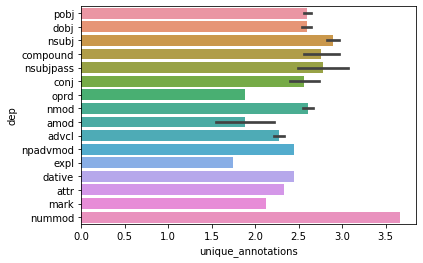

In [9]:
## combine with dep info
dep_annotation_data = pd.DataFrame(
    [
        mean_annotations_per_annotator,
        list(map(lambda x: x['label_dep'][0], parsed_annotated_data))
    ],
    index=['unique_annotations', 'dep']
).transpose()
## plot everything
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
sns.barplot(data=dep_annotation_data, y='dep', x='unique_annotations', orient='h', order=label_dep_counts.index)
plt.show()

Labels that appear after prepositions (`pobj`) and as direct objects (`dobj`) attract slightly fewer unique annotations than labels that appear as the subjects (`nsubj`) and in compound phrases (`compound`).

### Assess gender bias
Looking at the top N words in different categories, we see that there may be cases where "male" words may be more frequent than "female" words.

Let's try to quantify this more.

In [15]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
## stem all words
def tokenize_lemmatize(text, tokenizer, lemmatizer):
    return list(map(lambda x: lemmatizer.lemmatize(x), tokenizer.tokenize(text)))
def lemmatize_annotations(data, tokenizer, lemmatizer):
    data['label_lemmas'] = tokenize_lemmatize(data['label_norm'], tokenizer, lemmatizer)
    data['annotation_lemmas'] = list(map(lambda x: list(map(lambda y: tokenize_lemmatize(y, tokenizer, lemmatizer), x)), data['annotations_norm']))
    ## flatten
    data['flat_annotation_lemmas'] = [z for x in data['annotation_lemmas'] for y in x for z in y]
    return data
lemmatizer = WordNetLemmatizer()
word_tokenizer = WordPunctTokenizer()
test_word = 'women'
print(lemmatizer.lemmatize(test_word))
annotated_data = list(map(lambda x: lemmatize_annotations(x, word_tokenizer, lemmatizer), annotated_data))

woman


In [28]:
vocab = set()
vocab.update([y for x in annotated_data for y in x['label_lemmas']])
vocab.update([y for x in annotated_data for y in x['flat_annotation_lemmas']])

In [64]:
male_words = {'male', 'man', 'men', 'boy', 'guy', 'his', 'himself', 'he', 'him', 'brother', 'father', 'son'}
female_words = {'woman', 'girl', 'lady', 'her', 'hers', 'herself', 'she', 'female', 'sister', 'mother', 'daughter'}
neutral_words = {'person', 'people', 'baby', 'child', 'children', 'kid', 'adult', 'human', 'parent', 'sibling'}
# remove words if not in vocab
male_words = male_words & vocab
female_words = female_words & vocab
neutral_words = neutral_words & vocab
print(', '.join(map(lambda x: f"``{x}''", sorted(male_words))))
print(', '.join(map(lambda x: f"``{x}''", sorted(female_words))))
print(', '.join(map(lambda x: f"``{x}''", sorted(neutral_words))))

``boy'', ``brother'', ``father'', ``guy'', ``he'', ``him'', ``himself'', ``his'', ``male'', ``man'', ``men'', ``son''
``daughter'', ``female'', ``girl'', ``her'', ``herself'', ``lady'', ``mother'', ``she'', ``sister'', ``woman''
``adult'', ``baby'', ``child'', ``human'', ``kid'', ``parent'', ``people'', ``person'', ``sibling''


In [63]:
lemmatizer.lemmatize('women')

'woman'

In [56]:
## get male/female word counts
import pandas as pd
def get_word_counts(words, filter_words=None):
    if(filter_words is not None):
        words = list(filter(lambda x: x in filter_words, words))
    word_counts = pd.Series(words).value_counts()
    return word_counts

In [57]:
label_total_word_counts = pd.Series(get_word_counts([y for x in annotated_data for y in x['label_lemmas']]))
annotation_total_word_counts = pd.Series(get_word_counts([y for x in annotated_data for y in x['flat_annotation_lemmas']]))
N_label_total_words = label_total_word_counts.sum()
N_annotation_total_words = annotation_total_word_counts.sum()

In [65]:
word_sets = [male_words, female_words, neutral_words]
word_set_names = ['male', 'female', 'neutral']
for word_set_name_i, word_set_i in zip(word_set_names, word_sets):
    print(f'**** testing word set {word_set_name_i} ****')
    label_word_pct = label_total_word_counts.loc[word_set_i].sum() / N_label_total_words
    annotation_word_pct = annotation_total_word_counts.loc[word_set_i].sum() / N_annotation_total_words
    print(f'label word pct = {"{:1.3f}".format(label_word_pct)}')
    print(f'annotation word pct = {"{:1.3f}".format(annotation_word_pct)}')

**** testing word set male ****
label word pct = 0.109
annotation word pct = 0.091
**** testing word set female ****
label word pct = 0.062
annotation word pct = 0.059
**** testing word set neutral ****
label word pct = 0.060
annotation word pct = 0.066


<ipython-input-65-a7ffe89d7cad>:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  label_word_pct = label_total_word_counts.loc[word_set_i].sum() / N_label_total_words
